# Importar bibliotecas


In [ ]:
# !pip uninstall opencv-python -y
# !pip install opencv-contrib-python==3.4.2.17 --force-reinstall

In [108]:
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC # support vector classifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!ls /content/Curso

dicionario.csv	Teste  Treinamento


# Funções uteis

In [30]:
class Descritor:

  @staticmethod
  def get_sift_descritores(img_caminho):
      
      #Ler imagem
      img_teste = cv2.imread(img_caminho,0)
      
      #Redimensionar
      img_redimensionada = cv2.resize(img_teste,(360,360),
                                      interpolation = cv2.INTER_CUBIC) 
      
      #Remover ruído
      img_equalizada = cv2.equalizeHist(img_redimensionada)
      img_suavizada = cv2.GaussianBlur(img_equalizada,(9,9),1)
      
      #Algoritmo ORB - Oriented FAST and Ratated BRIEF,determinar pontos chaves
      sift = cv2.xfeatures2d.SIFT_create(nfeatures=512)
      pontos_chave = sift.detect(img_suavizada, None)
      
      pontos_chave, descritores = sift.compute(img_suavizada, pontos_chave)
      
      return descritores

  @staticmethod
  def salvar_descritor(descritor, caminho, nome_arquivo):
      descritor = descritor.reshape((1,descritor.size))
      arquivo = open(os.path.join(caminho, nome_arquivo), 'a')
      np.savetxt(arquivo, descritor, delimiter=',', fmt='%i')
      arquivo.close()     

  @staticmethod
  def carregar_descritores(caminho, nome_arquivo='orb_descritor.csv'):
    descritores = np.loadtxt(os.path.join(caminho, nome_arquivo), delimiter=',')
    print('formato do array de descritores: ', descritores.shape)
    return descritores

In [17]:
QUANTIDADE_DE_PALAVRAS_VITUAIS = 128

class PacoteDePalavras:

    def gerar_dicionario(self, lista_descritores):
        kmeans = KMeans(n_clusters = QUANTIDADE_DE_PALAVRAS_VITUAIS)
        kmeans = kmeans.fit(lista_descritores)
        self.dicionario = kmeans.cluster_centers_
        
    def histograma_de_frequencia(self, descritor):
        
        try:
            algoritmo_knn = NearestNeighbors(n_neighbors = 5)
            algoritmo_knn.fit(self.dicionario)
            mais_proximos = algoritmo_knn.kneighbors(descritor, return_distance = False).flatten()
            # flatten ->  transformar o array em uma dimensão

            histograma_caracteristicas = np.histogram(mais_proximos,bins=np.arange(self.dicionario.shape[0]+1))[0]

            return histograma_caracteristicas
    
        except AttributeError:
                print('O atributo dicionário não foi definido')
    def salvar_dicionario(self, caminho='', nome_dicionario='dicionario.csv'):
        try: 
            np.savetxt(os.path.join(caminho, nome_dicionario),self.dicionario, delimiter=',', fmt='%f')
            print('Dicionário salvo!!!')
        except AttributeError:
            print("Dicionário vazio")
            
    def carregar_dicionario(self, caminho='', nome_dicionario='dicionario.csv'):
        self.dicionario = np.loadtxt(os.path.join(caminho, nome_dicionario), delimiter='')   

def arquivo_diretorios(caminho):
    for raiz,diretorios,arquivos in os.walk(caminho):
      for arquivo in arquivos:
        if arquivo.endswith('.png'):
          yield arquivo

In [22]:
DICIONARIO_NOME = 'dicionario.csv'
dados_treinamento = ['Curso/Treinamento/positivos/','Curso/Treinamento/negativos/']

#Rotina para criação do dicionário de palavras virtuais

descritores = np.empty((0,128), dtype=np.uint8)

for caminho in dados_treinamento:
  for arquivo in arquivo_diretorios(caminho):
                sift_descritor = Descritor.get_sift_descritores(os.path.join(caminho,arquivo))
                descritores = np.append(descritores, sift_descritor, axis=0)
                
img_representacao = PacoteDePalavras()
img_representacao.gerar_dicionario(descritores)
img_representacao.salvar_dicionario('Curso/',  DICIONARIO_NOME)

Dicionário salvo!!!


In [23]:
NOME_DESCRITOR = 'sift_descritor.csv'
for caminho in dados_treinamento:
  caminho_descritor = os.path.join(caminho,NOME_DESCRITOR)

  if os.path.exists(caminho_descritor):
    os.remove(caminho_descritor)

  for arquivo in arquivo_diretorios(caminho):
    descritor = Descritor.get_sift_descritores(os.path.join(caminho, arquivo))
    histograma_descritor = img_representacao.histograma_de_frequencia(descritor)
    Descritor.salvar_descritor(histograma_descritor, caminho, NOME_DESCRITOR)
print('Extração de caracterísitca finalizada e descritores salvos!')

Extração de caracterísitca finalizada e descritores salvos!


In [38]:
descritores_treinamento = np.empty((0,QUANTIDADE_DE_PALAVRAS_VITUAIS))

for caminho in dados_treinamento:
  descritores_treinamento = np.append(descritores_treinamento,
                                      Descritor.carregar_descritores(caminho,NOME_DESCRITOR),axis=0)
descritores_treinamento.shape

formato do array de descritores:  (400, 128)
formato do array de descritores:  (400, 128)


(800, 128)

In [26]:
rotulos_treinamento = np.concatenate((np.ones(400,dtype=np.uint8),
                                      np.zeros(400,dtype=np.uint8)))
rotulos_teste = np.concatenate((np.ones(100,dtype=np.uint8),
                                np.zeros(100,dtype=np.uint8)))

In [32]:
dados_teste = ['Curso/Teste/positivos/', 'Curso/Teste/negativos/']

descritores_teste = np.empty((0, QUANTIDADE_DE_PALAVRAS_VITUAIS), dtype=np.uint8)

for caminho in dados_teste:
  for arquivo in arquivo_diretorios(caminho):
    img_descritor = Descritor.get_sift_descritores(os.path.join(caminho, arquivo))
    img_descritor = img_representacao.histograma_de_frequencia(img_descritor)
    img_dim_expandida = np.expand_dims(img_descritor, axis=0)
    descritores_teste = np.append(descritores_teste, img_dim_expandida, axis=0)
print('Descritores de teste finalizada!')

Descritores de teste finalizada!


In [33]:
print(rotulos_teste[0])
print(descritores_teste[0])

1
[26 17 11 16 22 44 26 16 22 12  6 27 11 22 29 24 34  9 18 22 15 20 31 16
 13 21 17  7 36 17 16 27 20 10 21  8 19  4 18 14 35 13 15 21 19 19 15 14
 30 14 20  7 30 38 28 17  6 35 36 22 17 27 14 23 13 15 10  8 11 13 31 23
 18  9 23 12 15 20 10 12 30 17 25 13 12 17 25 25 26 20 22 14 43 22 26 21
 18 21 24 11 57 15 33 22  5 13 22 29 23 24 36 16 15 27 25 21  8 11 26  8
 23 21  8 28 24 42  9 15]


# Implementação de deep learning

In [66]:
mlp_model = Sequential([
                        Dense(128,activation='relu',input_shape=(128,)),
                        Dropout(0,45),
                        Dense(32,activation='relu'),
                        Dense(1, activation='sigmoid')
                     ])
adam = Adam(learning_rate=0.0001)
mlp_model.compile(optimizer=adam ,loss='binary_crossentropy',metrics=['accuracy'])

historico = mlp_model.fit(descritores_treinamento,rotulos_treinamento, batch_size=100,
              epochs=200, validation_data=(descritores_teste,rotulos_teste))

Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 159us/step - loss: 12.3610 - accuracy: 0.4888 - val_loss: 8.3534 - val_accuracy: 0.4850
Epoch 2/200
800/800 [==============================] - 0s 33us/step - loss: 6.7767 - accuracy: 0.4850 - val_loss: 3.3886 - val_accuracy: 0.4950
Epoch 3/200
800/800 [==============================] - 0s 24us/step - loss: 3.3889 - accuracy: 0.5125 - val_loss: 2.7855 - val_accuracy: 0.5300
Epoch 4/200
800/800 [==============================] - 0s 26us/step - loss: 3.1800 - accuracy: 0.5450 - val_loss: 2.7603 - val_accuracy: 0.5550
Epoch 5/200
800/800 [==============================] - 0s 27us/step - loss: 2.5330 - accuracy: 0.5350 - val_loss: 1.8090 - val_accuracy: 0.5500
Epoch 6/200
800/800 [==============================] - 0s 25us/step - loss: 1.9701 - accuracy: 0.5462 - val_loss: 1.5363 - val_accuracy: 0.5500
Epoch 7/200
800/800 [==============================] - 0s 24us/step - loss: 1.6432 - acc

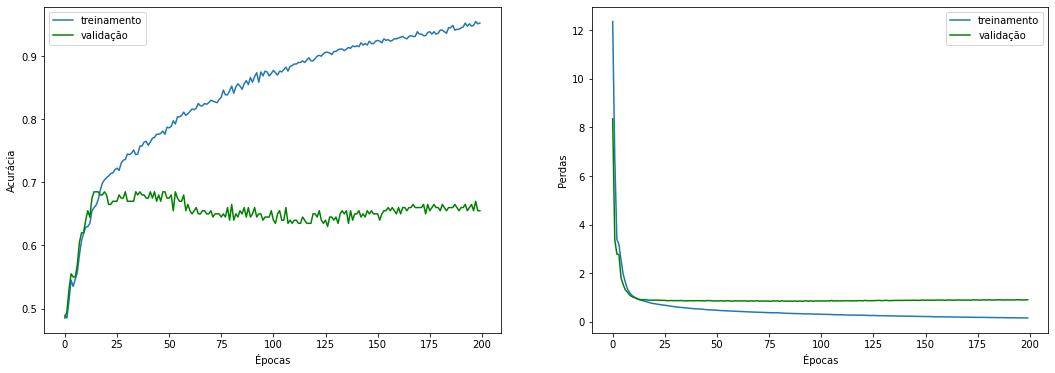

In [68]:
#Acurácia
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'],color='green')
plt.legend(['treinamento','validação'])
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
#Perdas
plt.subplot(122)
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'],color='green')
plt.legend(['treinamento','validação'])
plt.xlabel('Épocas')
plt.ylabel('Perdas')

plt.show()

In [77]:
nome_classe = {1: 'há pessoa(s)',
               0: 'não há pessoa(s)'}
def mlp_classificar(img_caminho):
  img_descritores = Descritor.get_sift_descritores(img_caminho)
  vetor_de_caracteristicas = img_representacao.histograma_de_frequencia(img_descritores)

  classe_prevista = mlp_model.predict_classes(np.expand_dims(vetor_de_caracteristicas,axis=0))
  print('\nclasse prevista: ',nome_classe[classe_prevista[0][0]],'\n')

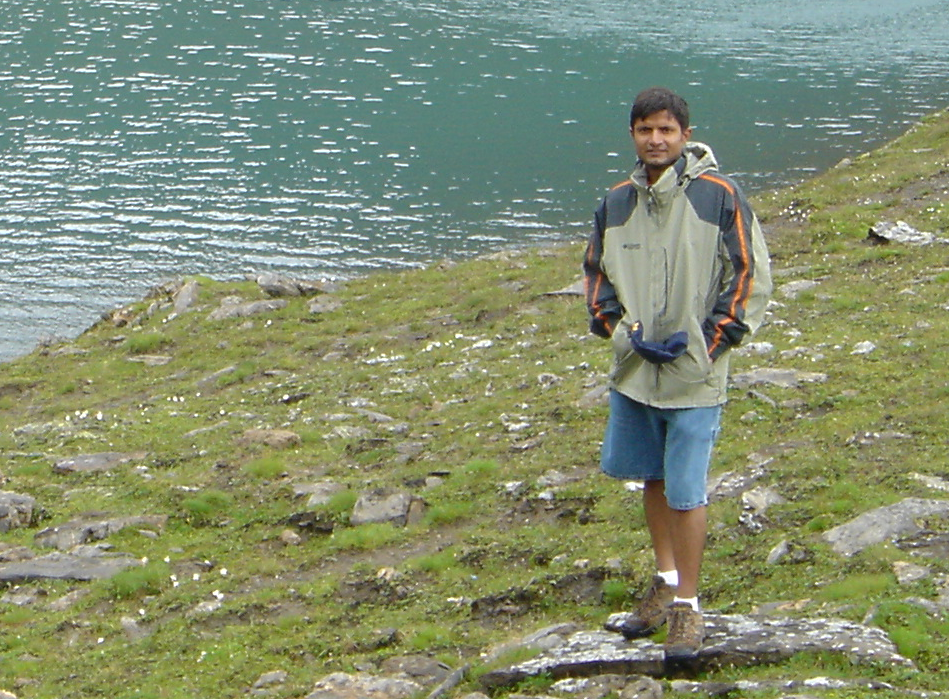


classe prevista:  há pessoa(s) 



In [86]:
imagem  = cv2.imread('Curso/Teste/positivos/crop_000016.png')
cv2_imshow(imagem)
mlp_classificar('Curso/Teste/positivos/crop_000016.png')

In [83]:
mlp_rotulos_previstos = mlp_model.predict_classes(descritores_teste)

print(confusion_matrix(rotulos_teste, mlp_rotulos_previstos))
print(classification_report(rotulos_teste, mlp_rotulos_previstos))

[[60 40]
 [29 71]]
              precision    recall  f1-score   support

           0       0.67      0.60      0.63       100
           1       0.64      0.71      0.67       100

    accuracy                           0.66       200
   macro avg       0.66      0.66      0.65       200
weighted avg       0.66      0.66      0.65       200



In [88]:
svm_model = SVC(gamma = 'scale')

svm_model.fit(descritores_treinamento,  rotulos_treinamento)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [92]:
def svm_classificar(caminho):
  img_descritores = Descritor.get_sift_descritores(caminho)
  vetor_caracterisiticas = img_representacao.histograma_de_frequencia(img_descritores)

  classe_prevista = svm_model.predict(np.expand_dims(vetor_caracterisiticas,axis=0))
  print('\nclasse prevista: ',nome_classe[classe_prevista[0]],'\n')

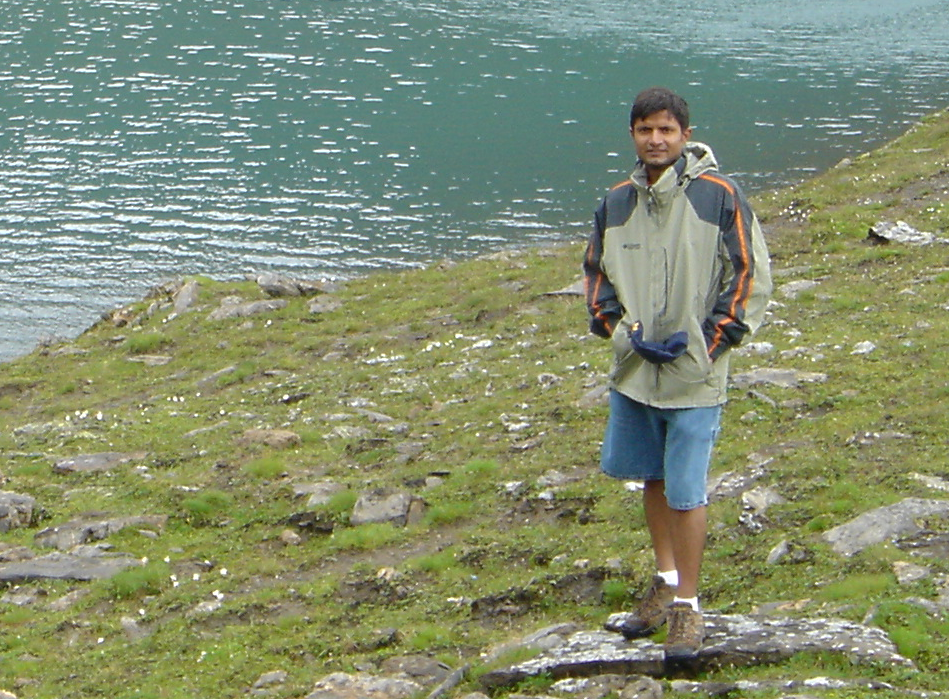


classe prevista:  há pessoa(s) 



In [93]:
imagem  = cv2.imread('Curso/Teste/positivos/crop_000016.png')
cv2_imshow(imagem)
svm_classificar('Curso/Teste/positivos/crop_000016.png')

In [95]:
rotulos_previstos_svm = svm_model.predict(descritores_teste)
print(confusion_matrix(rotulos_teste,rotulos_previstos_svm))
print('\n\n')
print(classification_report(rotulos_teste,rotulos_previstos_svm))

[[61 39]
 [24 76]]



              precision    recall  f1-score   support

           0       0.72      0.61      0.66       100
           1       0.66      0.76      0.71       100

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.68       200
weighted avg       0.69      0.69      0.68       200



In [97]:
class Descritor:

  @staticmethod
  def get_pixels(img_caminho):
      
      #Ler imagem
      img_teste = cv2.imread(img_caminho,0)
      
      #Redimensionar
      img_redimensionada = cv2.resize(img_teste,(360,360),
                                      interpolation = cv2.INTER_CUBIC) 
      
      imagem = img_redimensionada.flatten()
      imagem = imagem/255.0
      
      return imagem

  @staticmethod
  def salvar_descritor(descritor, caminho, nome_arquivo):
      descritor = descritor.reshape((1,descritor.size))
      arquivo = open(os.path.join(caminho, nome_arquivo), 'a')
      np.savetxt(arquivo, descritor, delimiter=',', fmt='%i')
      arquivo.close()     

  @staticmethod
  def carregar_descritores(caminho, nome_arquivo='orb_descritor.csv'):
    descritores = np.loadtxt(os.path.join(caminho, nome_arquivo), delimiter=',')
    print('formato do array de descritores: ', descritores.shape)
    return descritores

In [100]:
TAMANHO_ARRAY = 129600
pixel_treinamento = np.empty((0,TAMANHO_ARRAY))
pixel_teste = np.empty((0,TAMANHO_ARRAY))

for caminho in dados_treinamento:
  for arquivo in arquivo_diretorios(caminho):
    pixels = Descritor.get_pixels(os.path.join(caminho, arquivo))
    pixels_dim_exp = np.expand_dims(pixels, axis=0)
    pixel_treinamento = np.append(pixel_treinamento, pixels_dim_exp, axis=0)

print('dados treinamento: ', pixel_treinamento.shape)
for caminho in dados_teste:
  for arquivo in arquivo_diretorios(caminho):
    pixels = Descritor.get_pixels(os.path.join(caminho, arquivo))
    pixels_dim_exp = np.expand_dims(pixels, axis=0)
    pixel_teste = np.append(pixel_teste, pixels_dim_exp, axis=0)

print('dados teste: ',pixel_teste.shape)

dados treinamento:  (800, 129600)
dados teste:  (200, 129600)


Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 10s 13ms/step - loss: 1.7193 - accuracy: 0.5688 - val_loss: 0.7385 - val_accuracy: 0.6700
Epoch 2/100
800/800 [==============================] - 9s 11ms/step - loss: 1.2258 - accuracy: 0.6600 - val_loss: 0.4883 - val_accuracy: 0.8200
Epoch 3/100
800/800 [==============================] - 9s 11ms/step - loss: 1.0746 - accuracy: 0.7125 - val_loss: 0.4689 - val_accuracy: 0.8350
Epoch 4/100
800/800 [==============================] - 9s 11ms/step - loss: 0.9838 - accuracy: 0.6913 - val_loss: 0.3593 - val_accuracy: 0.8300
Epoch 5/100
800/800 [==============================] - 9s 11ms/step - loss: 0.8026 - accuracy: 0.7200 - val_loss: 0.3609 - val_accuracy: 0.8350
Epoch 6/100
800/800 [==============================] - 9s 12ms/step - loss: 0.6876 - accuracy: 0.7337 - val_loss: 0.3620 - val_accuracy: 0.8500
Epoch 7/100
800/800 [==============================] - 9s 12ms/step - loss: 0.6512 - accu

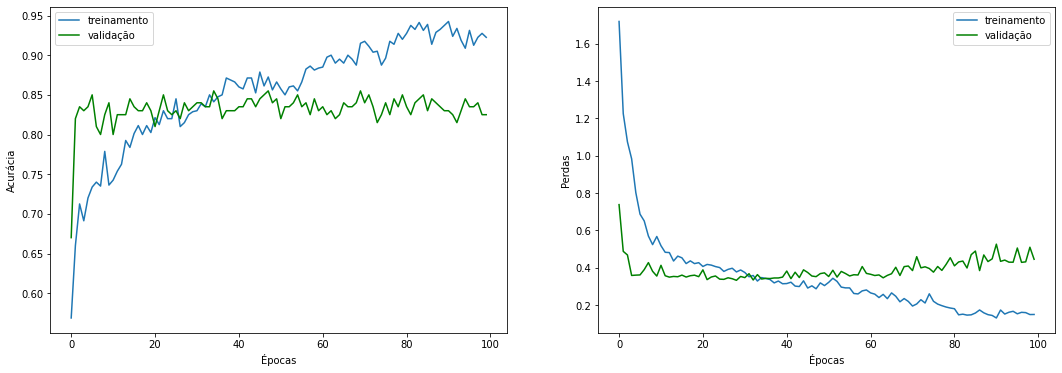

In [106]:
mlp_melhorada = Sequential([
    Dense(512, activation='relu',input_shape=(TAMANHO_ARRAY,)),
    Dropout(0.35),
    Dense(256, activation='relu'),
    Dropout(0.15),
    Dense(96, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

adam = Adam(learning_rate=0.0001)
mlp_melhorada.compile(optimizer = adam, loss='binary_crossentropy', metrics=['accuracy'])
historico = mlp_melhorada.fit(pixel_treinamento,rotulos_treinamento, batch_size=100,
              epochs=100, validation_data=(pixel_teste,rotulos_teste))

#Acurácia
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(historico.history['accuracy'])
plt.plot(historico.history['val_accuracy'],color='green')
plt.legend(['treinamento','validação'])
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
#Perdas
plt.subplot(122)
plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'],color='green')
plt.legend(['treinamento','validação'])
plt.xlabel('Épocas')
plt.ylabel('Perdas')

plt.show()


In [107]:
rotulos_previstos_mlp_melhorada = mlp_melhorada.predict_classes(pixel_teste)
print(confusion_matrix(rotulos_teste, rotulos_previstos_mlp_melhorada ))
print(classification_report(rotulos_teste, rotulos_previstos_mlp_melhorada ))

[[84 16]
 [19 81]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       100
           1       0.84      0.81      0.82       100

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200

